In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy import signal

from sklearn.preprocessing import MinMaxScaler

from operator import itemgetter

In [4]:
! pip install fastdtw

In [5]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [6]:
gt_2021_df = pd.read_csv(
    "../datasets/raw/2021_sub_region_1_daily_2021_US_New_York_daily_symptoms_dataset.csv"
)
gt_2021_df["date"] = pd.to_datetime(gt_2021_df["date"]).astype("datetime64[ns]")
gt_2021_df = gt_2021_df[gt_2021_df["sub_region_2"].isna()]
gt_2021_df.columns = gt_2021_df.columns.str.lower()
gt_2021_df

,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,place_id,date,symptom:abdominal obesity,symptom:abdominal pain,...,symptom:wart,symptom:water retention,symptom:weakness,symptom:weight gain,symptom:wheeze,symptom:xeroderma,symptom:xerostomia,symptom:yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-01-01,2.46,4.11,...,1.00,0.22,0.30,3.12,0.23,3.20,0.42,0.16,0.39,0.28
1,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-01-02,2.62,4.14,...,1.05,0.24,0.34,3.29,0.26,3.40,0.48,0.16,0.45,0.27
2,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-01-03,2.88,4.09,...,1.03,0.21,0.36,3.47,0.23,3.37,0.48,0.15,0.46,0.27
3,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-01-04,2.83,3.98,...,1.10,0.22,0.40,3.54,0.25,2.88,0.41,0.17,0.47,0.31
4,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-01-05,2.73,3.98,...,1.11,0.24,0.41,3.54,0.25,2.80,0.40,0.17,0.50,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-12-27,1.51,4.26,...,0.94,0.19,0.40,2.61,0.27,2.72,0.47,0.13,0.44,0.28
361,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-12-28,1.58,4.21,...,0.98,0.22,0.42,2.78,0.28,2.79,0.47,0.13,0.45,0.28
362,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-12-29,1.61,4.27,...,0.97,0.21,0.42,2.75,0.27,2.68,0.46,0.13,0.46,0.32
363,US,United States,New York,US-NY,NaN,NaN,ChIJqaUj8fBLzEwRZ5UY3sHGz90,2021-12-30,1.48,4.04,...,0.95,0.20,0.38,2.66,0.27,2.47,0.45,0.15,0.48,0.30


In [7]:
health_data_df = pd.read_csv(
    "../datasets/raw/New_York_State_Statewide_COVID-19_Testing.csv"
)

In [8]:
health_data_df["Test Date"] = pd.to_datetime(health_data_df["Test Date"])
health_data_2021_df = health_data_df[
    health_data_df["Test Date"].dt.to_period("Y") == "2021"
]
ny_health_data_2021_df = health_data_2021_df[
    health_data_2021_df["County"] == "STATEWIDE"
]
ny_health_data_2021_df = ny_health_data_2021_df.rename(
    columns={
        "Test Date": "date",
        "County": "county",
        "New Positives": "daily_new_positives",
        "Cumulative Number of Positives": "cumulative_positives",
        "Total Number of Tests Performed": "num_daily_tests",
        "Cumulative Number of Tests Performed": "cumulative_tests",
        "Test % Positive": "test_positivity_rate",
        "Geography": "geography",
    }
)
ny_health_data_2021_df["test_positivity_rate"] = (
    ny_health_data_2021_df["test_positivity_rate"].str.rstrip("%").astype("float")
    / 100.0
)
ny_health_data_2021_df

,date,county,daily_new_positives,cumulative_positives,num_daily_tests,cumulative_tests,test_positivity_rate,geography
22244,2021-12-31,STATEWIDE,85476,3555040,384365,88871159,0.2224,STATEWIDE
22317,2021-12-30,STATEWIDE,76555,3469564,339853,88486794,0.2253,STATEWIDE
22390,2021-12-29,STATEWIDE,74207,3393009,336469,88146941,0.2205,STATEWIDE
22463,2021-12-28,STATEWIDE,67090,3318802,362594,87810472,0.1850,STATEWIDE
22536,2021-12-27,STATEWIDE,40780,3251712,210996,87447878,0.1933,STATEWIDE
...,...,...,...,...,...,...,...,...
48524,2021-01-05,STATEWIDE,16648,1057676,197816,26333682,0.0842,STATEWIDE
48597,2021-01-04,STATEWIDE,12666,1041028,152402,26135866,0.0831,STATEWIDE
48670,2021-01-03,STATEWIDE,11209,1028362,134360,25983464,0.0834,STATEWIDE
48743,2021-01-02,STATEWIDE,11368,1017153,142345,25849104,0.0799,STATEWIDE


In [9]:
def filter_symptoms(df, symptoms_list):
    valid_columns = []
    for column in df.columns:
        if "symptom:" in str(column):
            symptom = column.split(":")[1]
            if symptom in symptoms_list:
                valid_columns.append(column)
        else:
            valid_columns.append(column)
    return df[valid_columns]

In [10]:
combined_df = gt_2021_df.set_index("date").join(
    ny_health_data_2021_df.set_index("date")
)
combined_df.drop(
    [
        "place_id",
        "country_region_code",
        "country_region",
        "sub_region_1",
        "sub_region_1_code",
        "sub_region_2",
        "sub_region_2_code",
        "county",
        "geography",
    ],
    axis=1,
    inplace=True,
)
symptoms_list = [
    "Fever",
    "Chills",
    "Cough",
    "Shortness of breath",
    "Sore throat",
    "Headache",
    "Fatigue",
    "Muscle weakness",
    "Anosmia",
    "Ageusia",
    "Nasal congestion",
    "Nausea",
    "Vomiting",
    "Diarrhea",
]
symptoms_list = [symptom.lower() for symptom in symptoms_list]
combined_df = filter_symptoms(combined_df, symptoms_list)

In [11]:
symptoms_file_names_dict = {
    "fever": "scenario1_fever.csv",
    "chills": "scenario1_chills.csv",
    "cough": "scenario1_cough.csv",
    "shortness of breath": "scenario1_shortness_of_breath.csv",
    "sore throat": "scenario1_sore_throat.csv",
    "headache": "scenario1_headache.csv",
    "fatigue": "scenario1_fatigue.csv",
    "anosmia": "scenario1_loss_of_smell.csv",
    "ageusia": "scenario1_loss_of_taste.csv",
    "nasal congestion": "scenario1_congestion.csv",
    "nausea": "scenario1_nausea.csv",
    "vomiting": "scenario1_vomiting.csv",
    "diarrhea": "scenario1_diarrhea.csv",
}
chills_df = pd.read_csv("../datasets/raw/media_coverage/scenario1_chills.csv")
chills_df
for symptom, filename in symptoms_file_names_dict.items():
    symptom_df = pd.read_csv("../datasets/raw/media_coverage/" + filename)
    combined_df["media:" + symptom] = symptom_df["count"].to_numpy()
combined_df

ValueError: Length of values (366) does not match length of index (365)

In [12]:
len(symptoms_list)

15

In [ ]:
combined_df

,symptom:ageusia,symptom:anosmia,symptom:chills,symptom:cough,symptom:diarrhea,symptom:fatigue,symptom:fever,symptom:headache,symptom:muscle weakness,symptom:nasal congestion,...,media:shortness of breath,media:sore throat,media:headache,media:fatigue,media:anosmia,media:ageusia,media:nasal congestion,media:nausea,media:vomiting,media:diarrhea
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.32,0.37,0.30,3.75,3.50,3.72,3.49,4.49,0.16,1.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,0.36,0.42,0.30,3.90,3.38,3.95,3.65,4.08,0.16,1.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,0.34,0.46,0.29,3.88,3.39,4.03,3.69,3.83,0.17,1.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,0.28,0.34,0.31,3.93,3.37,4.34,4.00,3.93,0.22,1.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.27,0.32,0.33,3.98,3.38,4.42,4.11,4.31,0.22,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.30,0.41,0.59,11.15,4.21,4.14,8.29,4.26,0.19,4.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28,0.31,0.43,0.63,11.92,4.18,4.41,9.06,4.57,0.21,4.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,0.33,0.43,0.58,11.88,4.15,4.29,8.78,4.48,0.20,4.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
combined_df = gt_2021_df.set_index("date").join(
    ny_health_data_2021_df.set_index("date")
)
combined_df.drop(
    [
        "place_id",
        "country_region_code",
        "country_region",
        "sub_region_1",
        "sub_region_1_code",
        "sub_region_2",
        "sub_region_2_code",
        "county",
        "geography",
    ],
    axis=1,
    inplace=True,
)
combined_df = filter_symptoms(combined_df, symptoms_list)
combined_df

,symptom:ageusia,symptom:anosmia,symptom:chills,symptom:cough,symptom:diarrhea,symptom:fatigue,symptom:fever,symptom:headache,symptom:muscle weakness,symptom:nasal congestion,symptom:nausea,symptom:shortness of breath,symptom:sore throat,symptom:vomiting,daily_new_positives,cumulative_positives,num_daily_tests,cumulative_tests,test_positivity_rate
date,,,,,,,,,,,,,,,,,,,
2021-01-01,0.32,0.37,0.30,3.75,3.50,3.72,3.49,4.49,0.16,1.66,2.12,0.65,1.40,2.85,15074,1005785,202446,25706759,0.0745
2021-01-02,0.36,0.42,0.30,3.90,3.38,3.95,3.65,4.08,0.16,1.66,1.90,0.69,1.43,2.40,11368,1017153,142345,25849104,0.0799
2021-01-03,0.34,0.46,0.29,3.88,3.39,4.03,3.69,3.83,0.17,1.66,1.84,0.70,1.40,2.37,11209,1028362,134360,25983464,0.0834
2021-01-04,0.28,0.34,0.31,3.93,3.37,4.34,4.00,3.93,0.22,1.48,1.85,0.77,1.42,2.27,12666,1041028,152402,26135866,0.0831
2021-01-05,0.27,0.32,0.33,3.98,3.38,4.42,4.11,4.31,0.22,1.51,1.81,0.74,1.40,2.14,16648,1057676,197816,26333682,0.0842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.30,0.41,0.59,11.15,4.21,4.14,8.29,4.26,0.19,4.00,2.26,0.80,4.22,3.26,40780,3251712,210996,87447878,0.1933
2021-12-28,0.31,0.43,0.63,11.92,4.18,4.41,9.06,4.57,0.21,4.37,2.27,0.82,4.36,3.19,67090,3318802,362594,87810472,0.1850
2021-12-29,0.33,0.43,0.58,11.88,4.15,4.29,8.78,4.48,0.20,4.48,2.29,0.83,4.36,3.15,74207,3393009,336469,88146941,0.2205


In [13]:
def get_spearmanr(df):
    new_cases = df["daily_new_positives"].astype(float).to_numpy()
    symptoms_list = [
        "Fever",
        "Chills",
        "Cough",
        "Shortness of breath",
        "Sore throat",
        "Headache",
        "Fatigue",
        "Muscle weakness",
        "Anosmia",
        "Sore throat",
        "Ageusia",
        "Nasal congestion",
        "Nausea",
        "Vomiting",
        "Diarrhea",
    ]
    symptoms_list = [symptom.lower() for symptom in symptoms_list]
    symptom_scc_dict = {}
    for symptom in symptoms_list:
        symptom_trend_values = df["symptom:" + symptom].astype(float).to_numpy()
        if np.isnan(new_cases).any() or np.isnan(symptom_trend_values).any():
            nas = np.logical_or(np.isnan(new_cases), np.isnan(symptom_trend_values))
            symptom_pcc = spearmanr(new_cases[~nas], symptom_trend_values[~nas])
        else:
            symptom_pcc = spearmanr(new_cases, symptom_trend_values)
        symptom_scc_dict[symptom] = symptom_pcc
    return symptom_scc_dict

In [14]:
def plot_cases(df):
    plt.plot(df.index, df["daily_new_positives"].astype(float))
    plt.xlabel("Date")
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%Y"))
    plt.xticks(rotation=45)
    plt.ylabel("New Daily Positive Cases")
    plt.title("NY State 2021 Daily New Positive Cases")
    # plt.savefig("../plots/basic/ny_2021_daily_new_cases.png")


def plot_symptoms(df):
    LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
    NUM_COLORS = 20
    NUM_STYLES = len(LINE_STYLES)
    cm = plt.get_cmap("gist_rainbow")
    symptoms_list = [
        "Fever",
        "Chills",
        "Cough",
        "Shortness of breath",
        "Sore throat",
        "Headache",
        "Fatigue",
        "Muscle weakness",
        "Anosmia",
        "Sore throat",
        "Ageusia",
        "Nasal congestion",
        "Nausea",
        "Vomiting",
        "Diarrhea",
    ]
    symptoms_list = [symptom.lower() for symptom in symptoms_list]
    for i, symptom in enumerate(symptoms_list):
        scaler = MinMaxScaler()
        scaled_rsv = (
            df["symptom:" + symptom].to_numpy().reshape(-1, 1)
            / df["symptom:" + symptom].max()
        )
        scaled_rsv = df["symptom:" + symptom].to_numpy().reshape(-1, 1)
        plt.plot(
            df.index,
            scaled_rsv,
            label=symptom,
            color=cm(i // NUM_STYLES * float(NUM_STYLES / NUM_COLORS)),
            linestyle=LINE_STYLES[i % NUM_STYLES],
        )
    plt.xlabel("Date")
    plt.ylabel("Symptom RSV")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("NY State 2021 Daily Symptom RSV")
    # plt.savefig("../plots/basic/ny_2021_daily_symptoms.png", bbox_inches="tight")

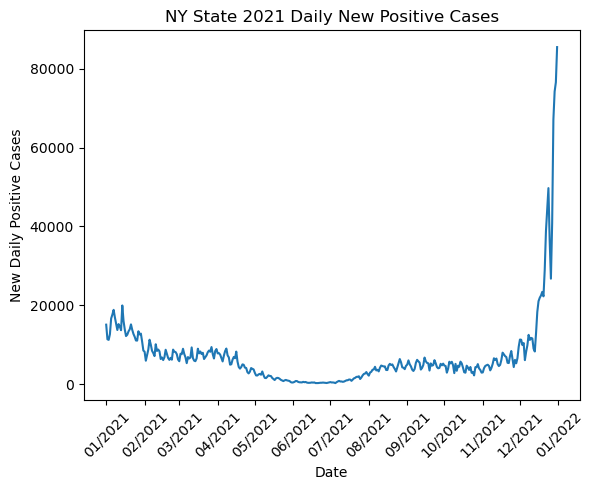

In [15]:
plot_cases(combined_df)

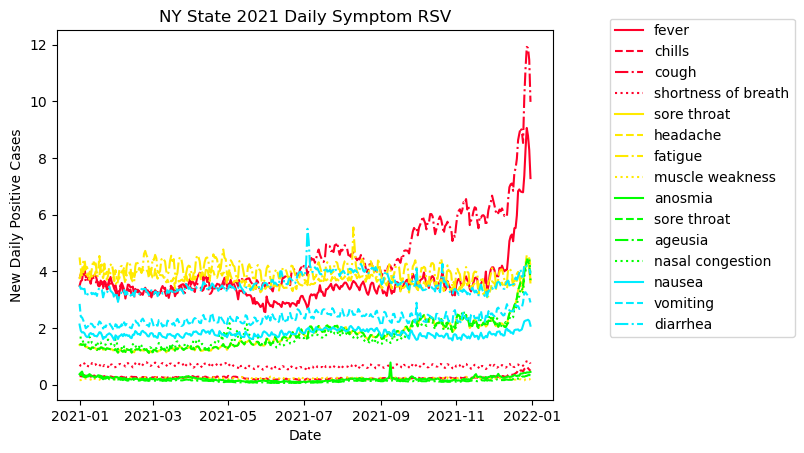

In [16]:
plot_symptoms(combined_df)

In [51]:
get_spearmanr(combined_df)

{'fever': SpearmanrResult(correlation=0.6229423362741601, pvalue=1.2983883521696628e-40),
 'chills': SpearmanrResult(correlation=0.8040371227643239, pvalue=5.673644716786914e-84),
 'cough': SpearmanrResult(correlation=-0.021246615356380335, pvalue=0.6857940764660939),
 'shortness of breath': SpearmanrResult(correlation=0.49125865398332363, pvalue=1.4314987228026993e-23),
 'sore throat': SpearmanrResult(correlation=-0.1614989523970378, pvalue=0.0019668524940598888),
 'headache': SpearmanrResult(correlation=0.4702902019924343, pvalue=1.7449455523668827e-21),
 'fatigue': SpearmanrResult(correlation=0.05531336065211122, pvalue=0.2919092111989669),
 'muscle weakness': SpearmanrResult(correlation=-0.10103531044957409, pvalue=0.053781331736047794),
 'anosmia': SpearmanrResult(correlation=0.8445370007185143, pvalue=1.7118194306095571e-100),
 'ageusia': SpearmanrResult(correlation=0.9039749414365347, pvalue=5.328190905604589e-136),
 'nasal congestion': SpearmanrResult(correlation=-0.08514399815

### Apply Dynamic Time Warping

In [32]:
def scaled_symptom_dtw(df, symptom):
    case_scaler = MinMaxScaler()
    symptom_scaler = MinMaxScaler()
    norm_cases = case_scaler.fit_transform(
        df["daily_new_positives"].to_numpy().reshape(-1, 1)
    )
    norm_symptom = symptom_scaler.fit_transform(
        df["symptom:" + symptom].to_numpy().reshape(-1, 1)
    )
    return fastdtw(norm_symptom, norm_cases, dist=euclidean)


# Basically useless due to differences in scales
def symptom_dtw(df, symptom):
    return fastdtw(df["daily_new_positives"], df["symptom:" + symptom])

In [33]:
def plot_individual_symptom_and_cases(df, symptoms_list):
    for symptom in symptoms_list:
        fig, ax = plt.subplots()

        symptom_col = "symptom:{}".format(symptom)
        ax.plot(
            df.index, df[symptom_col].astype(float), color="tab:blue", label=symptom
        )

        ax.set_xlabel("Date")
        ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%Y"))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.set_ylabel("Relative Search Volume")

        ax2 = ax.twinx()

        case_col = "daily_new_positives"
        ax2.plot(
            df.index,
            df[case_col].astype(float),
            color="tab:red",
            label="daily_new_positives",
        )
        ax2.set_ylabel("Daily New Positives")

        # Plot legend
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1 + h2, l1 + l2)

        plt.xticks(rotation=45)
        title = "{} Search Trend vs Reported Cases".format(symptom.title())
        save_path = "../plots/dtw/ny_2021_{}_vs_cases.png".format(symptom)
        plt.title(title)
        # plt.savefig(
        #     save_path,
        #     bbox_inches="tight",
        # )
        plt.show()

In [34]:
dtw_symptom_dict = {}
for symptom in symptoms_list:
    lag, _ = scaled_symptom_dtw(combined_df, symptom)
    dtw_symptom_dict[symptom] = lag
top_5 = dict(
    sorted(dtw_symptom_dict.items(), key=itemgetter(1), reverse=False)[:5]
).keys()

{'fever': 9.564585147911636,
 'cough': 10.271705637950722,
 'sore throat': 12.0697123083776,
 'nasal congestion': 12.624263248217536,
 'anosmia': 13.377791608742406}

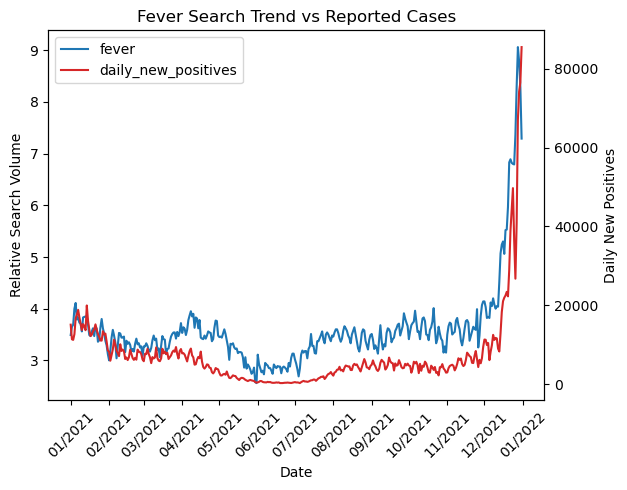

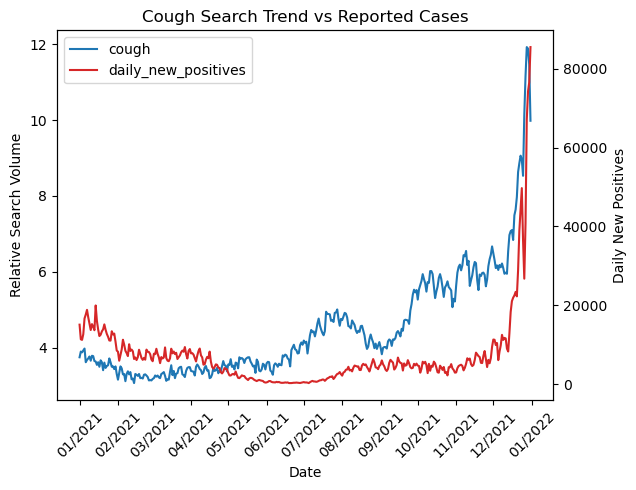

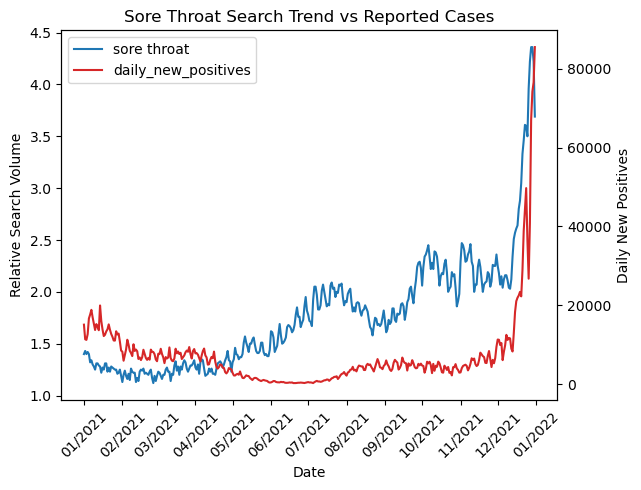

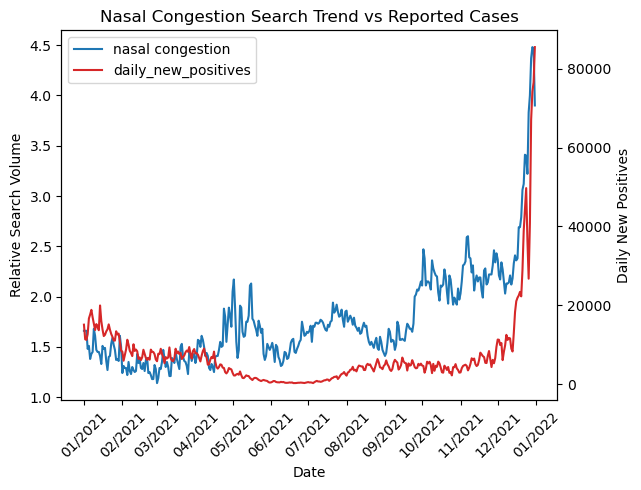

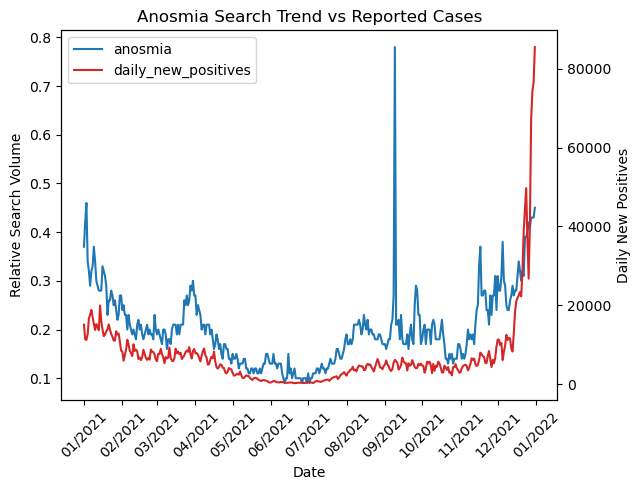

In [35]:
plot_individual_symptom_and_cases(combined_df, top_5)

### Simple Lag Analysis

In [29]:
def simple_lag_analysis(df, symptom):
    cases = df["daily_new_positives"].to_numpy()
    symptom_rsv = df["symptom:" + symptom].to_numpy()
    spearman_values = []
    # Calculate over month window
    for i in range(31):
        value = spearmanr(
            symptom_rsv[: len(cases) // 2], cases[i : i + len(cases) // 2]
        )
        spearman_values.append(value[0])
    spearman_values = np.array(spearman_values)
    lag = np.argmax(spearman_values)
    return lag, spearman_values

In [28]:
simple_symptom_lag_dict = {}
for symptom in symptoms_list:
    lag, _ = simple_lag_analysis(combined_df, symptom)
    simple_symptom_lag_dict[symptom] = lag
simple_symptom_lag_dict

{'fever': 1,
 'chills': 1,
 'cough': 2,
 'shortness of breath': 16,
 'sore throat': 2,
 'headache': 2,
 'fatigue': 16,
 'muscle weakness': 22,
 'anosmia': 4,
 'ageusia': 4,
 'nasal congestion': 11,
 'nausea': 25,
 'vomiting': 25,
 'diarrhea': 24}

### Apply Cross Correlation (Not working yet)

In [68]:
def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode="same") / np.sqrt(
        signal.correlate(y1, y1, mode="same")[int(n / 2)]
        * signal.correlate(y2, y2, mode="same")[int(n / 2)]
    )

    delay_arr = np.linspace(-0.5 * n / sr, 0.5 * n / sr, n)
    delay = delay_arr[np.argmax(corr)]
    print("y2 is " + str(delay) + " behind y1")

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title("Lag: " + str(np.round(delay, 3)) + " s")
    plt.xlabel("Lag")
    plt.ylabel("Correlation coeff")
    plt.show()


def plot_xcorr(x, y):
    "Plot cross-correlation (full) between two signals."
    N = max(len(x), len(y))
    n = min(len(x), len(y))

    if N == len(y):
        lags = np.arange(-N + 1, n)
    else:
        lags = np.arange(-n + 1, N)
    c = signal.correlate(x / np.std(x), y / np.std(y), "full")

    plt.plot(lags, c / n)
    plt.show()

In [80]:
symptom = "fever"
# cases = combined_df['New Positives'].to_numpy().reshape(-1, 1)
# symptom_rsv = combined_df['symptom:' + symptom].to_numpy().reshape(-1, 1)
# case_scaler = MinMaxScaler()
# symptom_scaler = MinMaxScaler()
# norm_cases = case_scaler.fit_transform(combined_df['New Positives'].to_numpy().reshape(-1, 1))
# norm_symptom = symptom_scaler.fit_transform(combined_df['symptom:' + symptom].to_numpy().reshape(-1, 1))
# plot_xcorr(cases[:100], cases[50:150])
cases = combined_df["daily_new_positives"].to_numpy()
symptom_rsv = combined_df["symptom:" + symptom].to_numpy()
case_scaler = MinMaxScaler()
symptom_scaler = MinMaxScaler()
norm_cases = case_scaler.fit_transform(cases.reshape(-1, 1))
norm_symptom = symptom_scaler.fit_transform(symptom_rsv.reshape(-1, 1))
correlation = np.correlate(norm_cases.squeeze(), norm_symptom.squeeze(), mode="same")
delay = np.argmax(correlation) - int(len(correlation) / 2)
delay

0

In [78]:
correlation

array([1.66230178, 1.66302372, 1.64749605, 1.61837336, 1.58775083,
       1.57222171, 1.57478003, 1.57463162, 1.57164758, 1.55889606,
       1.52957695, 1.49763081, 1.47874714, 1.47872477, 1.48884897,
       1.49288275, 1.48024224, 1.45911859, 1.43863895, 1.42637686,
       1.42949716, 1.44512165, 1.45438863, 1.45052597, 1.43533676,
       1.42036811, 1.41575856, 1.43125639, 1.45797827, 1.47450779,
       1.47750732, 1.4779903 , 1.45593357, 1.45433129, 1.4784721 ,
       1.51232096, 1.52933859, 1.53895318, 1.53166684, 1.52761239,
       1.54061468, 1.57272274, 1.60305346, 1.63378314, 1.64898666,
       1.64018277, 1.64013793, 1.65917892, 1.69491161, 1.73591357,
       1.76551779, 1.7771276 , 1.76822343, 1.76481805, 1.77704222,
       1.81774416, 1.86893799, 1.9045287 , 1.92069265, 1.91433963,
       1.91112691, 1.92720368, 1.97022605, 2.01333417, 2.05510705,
       2.06898438, 2.05863099, 2.04034504, 2.05376868, 2.09696366,
       2.14739404, 2.19055163, 2.19323211, 2.17937651, 2.17341